# Turbofan Engine Remaining Useful Life (RUL) Prediction



#### SECTION 1: SETUP AND IMPORTS


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print("📊 Ready to start the Turbofan Engine RUL Prediction project")


✅ Libraries imported successfully!
📊 Ready to start the Turbofan Engine RUL Prediction project


#### STEP 2: Load and Examine the Data

In [86]:
# Define column names for the dataset (26 columns total)
columns = ['unit_number', 'time_cycles'] + \
          [f'operational_setting_{i}' for i in range(1, 4)] + \
          [f'sensor_{i}' for i in range(1, 22)]

print("🔍 Column names defined:")
print(f"Total columns expected: 26")
print("Columns:", columns[:10], "... and 16 more")

# Load the datasets
# Note: Make sure your data files are uploaded to Colab
def load_data():
    """Load all training, test, and RUL datasets"""
    datasets = {}

    # Load training data
    for i in range(1, 5):
        try:
            # Read with proper space separation and handle extra spaces
            train_data = pd.read_csv(f'train_FD00{i}.txt', sep='\s+', header=None)
            # Only assign column names if we have the right number of columns
            if len(train_data.columns) == 26:
                train_data.columns = columns
            else:
                print(f"⚠️ train_FD00{i} has {len(train_data.columns)} columns, expected 26")
                # Use generic column names
                train_data.columns = [f'col_{j}' for j in range(len(train_data.columns))]
            datasets[f'train_FD00{i}'] = train_data
            print(f"✅ Loaded train_FD00{i}: Shape {train_data.shape}")
        except FileNotFoundError:
            print(f"❌ train_FD00{i}.txt not found")
        except Exception as e:
            print(f"❌ Error loading train_FD00{i}: {e}")

    # Load test data
    for i in range(1, 5):
        try:
            test_data = pd.read_csv(f'test_FD00{i}.txt', sep='\s+', header=None)
            if len(test_data.columns) == 26:
                test_data.columns = columns
            else:
                print(f"⚠️ test_FD00{i} has {len(test_data.columns)} columns, expected 26")
                test_data.columns = [f'col_{j}' for j in range(len(test_data.columns))]
            datasets[f'test_FD00{i}'] = test_data
            print(f"✅ Loaded test_FD00{i}: Shape {test_data.shape}")
        except FileNotFoundError:
            print(f"❌ test_FD00{i}.txt not found")
        except Exception as e:
            print(f"❌ Error loading test_FD00{i}: {e}")

    # Load RUL data
    for i in range(1, 5):
        try:
            rul_data = pd.read_csv(f'RUL_FD00{i}.txt', sep='\s+', header=None, names=['RUL'])
            datasets[f'RUL_FD00{i}'] = rul_data
            print(f"✅ Loaded RUL_FD00{i}: Shape {rul_data.shape}")
        except FileNotFoundError:
            print(f"❌ RUL_FD00{i}.txt not found")
        except Exception as e:
            print(f"❌ Error loading RUL_FD00{i}: {e}")

    return datasets

# Load all datasets
print("📂 Loading datasets...")
data = load_data()
print("\n🎉 Data loading completed!")

🔍 Column names defined:
Total columns expected: 26
Columns: ['unit_number', 'time_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'] ... and 16 more
📂 Loading datasets...
✅ Loaded train_FD001: Shape (20631, 26)
✅ Loaded train_FD002: Shape (53759, 26)
✅ Loaded train_FD003: Shape (24720, 26)
✅ Loaded train_FD004: Shape (61249, 26)
✅ Loaded test_FD001: Shape (13096, 26)
✅ Loaded test_FD002: Shape (33991, 26)
✅ Loaded test_FD003: Shape (16596, 26)
✅ Loaded test_FD004: Shape (41214, 26)
✅ Loaded RUL_FD001: Shape (100, 1)
✅ Loaded RUL_FD002: Shape (259, 1)
✅ Loaded RUL_FD003: Shape (100, 1)
✅ Loaded RUL_FD004: Shape (248, 1)

🎉 Data loading completed!


#### STEP 3: Data Exploration and Analysis

In [87]:
def explore_dataset(train_data, dataset_name):
    """Explore a single dataset"""
    print(f"\n📊 Exploring {dataset_name}")
    print("="*50)

    # Basic info
    print(f"Dataset shape: {train_data.shape}")
    print(f"Number of unique engines: {train_data['unit_number'].nunique()}")
    print(f"Time cycles range: {train_data['time_cycles'].min()} - {train_data['time_cycles'].max()}")

    # Display first few rows
    print("\n📋 First 5 rows:")
    print(train_data.head())

    # Statistical summary
    print("\n📈 Statistical Summary (first 10 columns):")
    print(train_data.iloc[:, :10].describe())

    # Check for missing values
    missing_values = train_data.isnull().sum()
    if missing_values.sum() > 0:
        print(f"\n⚠️ Missing values found: {missing_values.sum()}")
    else:
        print("\n✅ No missing values found")

    return train_data

# Explore FD001 dataset as an example
if 'train_FD001' in data:
    train_fd001 = explore_dataset(data['train_FD001'], 'FD001 Training Data')
else:
    print("⚠️ train_FD001 not available. Please check if the file was loaded correctly.")



📊 Exploring FD001 Training Data
Dataset shape: (20631, 26)
Number of unique engines: 100
Time cycles range: 1 - 362

📋 First 5 rows:
   unit_number  time_cycles  operational_setting_1  operational_setting_2  \
0            1            1                -0.0007                -0.0004   
1            1            2                 0.0019                -0.0003   
2            1            3                -0.0043                 0.0003   
3            1            4                 0.0007                 0.0000   
4            1            5                -0.0019                -0.0002   

   operational_setting_3  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
0                  100.0    518.67    641.82   1589.70   1400.60     14.62   
1                  100.0    518.67    642.15   1591.82   1403.14     14.62   
2                  100.0    518.67    642.35   1587.99   1404.20     14.62   
3                  100.0    518.67    642.35   1582.79   1401.87     14.62   
4            

#### STEP 4: Create RUL Labels for Training Data


🔧 Adding RUL labels to training data...
📊 Using 'unit_number' as unit identifier and 'time_cycles' as time cycles
✅ Added RUL to train_FD001
📊 Using 'unit_number' as unit identifier and 'time_cycles' as time cycles
✅ Added RUL to train_FD002
📊 Using 'unit_number' as unit identifier and 'time_cycles' as time cycles
✅ Added RUL to train_FD003
📊 Using 'unit_number' as unit identifier and 'time_cycles' as time cycles
✅ Added RUL to train_FD004


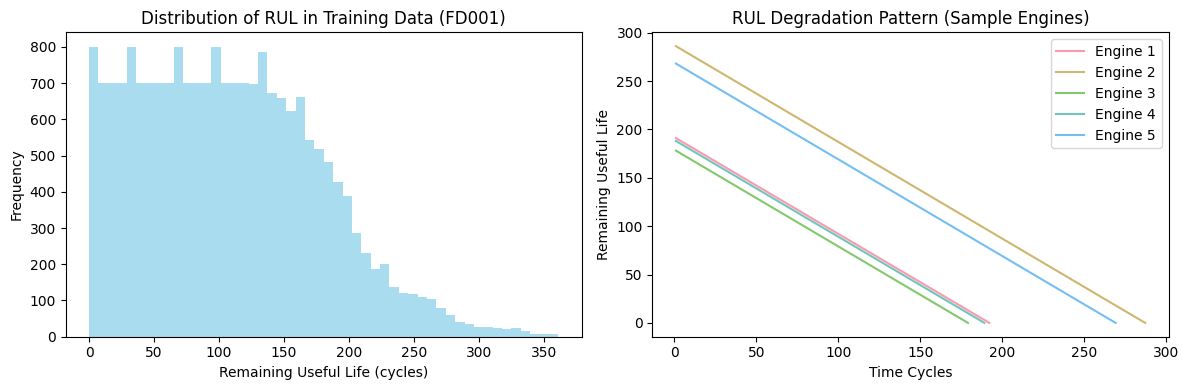

In [88]:
def add_rul_to_training_data(train_data):
    """Add RUL (Remaining Useful Life) column to training data"""
    train_data_with_rul = train_data.copy()

    # Get the first column name (should be unit_number or equivalent)
    unit_col = train_data_with_rul.columns[0]
    time_col = train_data_with_rul.columns[1]

    print(f"📊 Using '{unit_col}' as unit identifier and '{time_col}' as time cycles")

    # Calculate RUL for each engine
    rul_list = []

    for unit in train_data_with_rul[unit_col].unique():
        unit_data = train_data_with_rul[train_data_with_rul[unit_col] == unit]
        max_cycle = unit_data[time_col].max()

        # RUL = max_cycle - current_cycle for each row
        unit_rul = max_cycle - unit_data[time_col]
        rul_list.extend(unit_rul.tolist())

    train_data_with_rul['RUL'] = rul_list
    return train_data_with_rul

# Add RUL to training datasets
print("\n🔧 Adding RUL labels to training data...")
for key in data.keys():
    if key.startswith('train_'):
        try:
            data[key] = add_rul_to_training_data(data[key])
            print(f"✅ Added RUL to {key}")
        except Exception as e:
            print(f"❌ Error adding RUL to {key}: {e}")

# Display RUL distribution for FD001
if 'train_FD001' in data and 'RUL' in data['train_FD001'].columns:
    try:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.hist(data['train_FD001']['RUL'], bins=50, alpha=0.7, color='skyblue')
        plt.title('Distribution of RUL in Training Data (FD001)')
        plt.xlabel('Remaining Useful Life (cycles)')
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        # Show RUL for first few engines
        unit_col = data['train_FD001'].columns[0]
        time_col = data['train_FD001'].columns[1]
        sample_engines = data['train_FD001'][unit_col].unique()[:5]

        for engine in sample_engines:
            engine_data = data['train_FD001'][data['train_FD001'][unit_col] == engine]
            plt.plot(engine_data[time_col], engine_data['RUL'],
                    label=f'Engine {engine}', alpha=0.7)

        plt.title('RUL Degradation Pattern (Sample Engines)')
        plt.xlabel('Time Cycles')
        plt.ylabel('Remaining Useful Life')
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"❌ Error creating RUL plots: {e}")
else:
    print("⚠️ Cannot create RUL plots - data not available")


#### STEP 5: Feature Engineering

In [89]:
def create_features(data):
    """Create additional features from sensor data"""
    feature_data = data.copy()

    # Get sensor columns (handle both naming conventions)
    sensor_cols = [col for col in data.columns if 'sensor' in col.lower() or (col.startswith('col_') and col != 'col_0' and col != 'col_1')]

    if len(sensor_cols) == 0:
        print("⚠️ No sensor columns found. Using all numeric columns except unit_number and time_cycles")
        # Use all numeric columns except the first two (unit_number, time_cycles)
        numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
        sensor_cols = [col for col in numeric_cols if col not in ['unit_number', 'time_cycles', 'col_0', 'col_1']]

    print(f"📊 Found {len(sensor_cols)} sensor columns for feature engineering")

    # Create rolling statistics (window of 5 cycles) - limit to first 5 sensors
    for col in sensor_cols[:5]:
        try:
            feature_data[f'{col}_rolling_mean'] = feature_data.groupby(feature_data.columns[0])[col].rolling(window=5, min_periods=1).mean().reset_index(drop=True)
            feature_data[f'{col}_rolling_std'] = feature_data.groupby(feature_data.columns[0])[col].rolling(window=5, min_periods=1).std().reset_index(drop=True)
        except Exception as e:
            print(f"⚠️ Error creating rolling features for {col}: {e}")

    # Create lag features - limit to first 3 sensors
    for col in sensor_cols[:3]:
        try:
            feature_data[f'{col}_lag1'] = feature_data.groupby(feature_data.columns[0])[col].shift(1)
            feature_data[f'{col}_lag2'] = feature_data.groupby(feature_data.columns[0])[col].shift(2)
        except Exception as e:
            print(f"⚠️ Error creating lag features for {col}: {e}")

    # Fill NaN values created by rolling and lag features
    feature_data = feature_data.bfill().ffill()

    return feature_data

print("\n🔨 Creating features...")
# Apply feature engineering to FD001
if 'train_FD001' in data:
    try:
        data['train_FD001'] = create_features(data['train_FD001'])
        data['test_FD001'] = create_features(data['test_FD001'])
        print(f"✅ Features created for FD001. New shape: {data['train_FD001'].shape}")
    except Exception as e:
        print(f"❌ Error creating features for FD001: {e}")
else:
    print("⚠️ train_FD001 not available for feature engineering")



🔨 Creating features...
📊 Found 21 sensor columns for feature engineering
📊 Found 21 sensor columns for feature engineering
✅ Features created for FD001. New shape: (20631, 43)


#### STEP 6: Data Preprocessing

In [90]:
def preprocess_data(train_data, test_data):
    """Preprocess training and test data"""

    # Get the first two columns (should be unit_number and time_cycles)
    id_cols = train_data.columns[:2].tolist()

    # Select features (exclude unit_number, time_cycles, and RUL for feature matrix)
    feature_cols = [col for col in train_data.columns
                   if col not in id_cols + ['RUL']]

    print(f"📊 Using {len(feature_cols)} features for training")
    print(f"🔍 First 5 features: {feature_cols[:5]}")

    # Prepare training data
    X_train = train_data[feature_cols]
    y_train = train_data['RUL']

    # For test data, we need only the last cycle of each engine
    # This matches the RUL prediction task requirement
    unit_col = test_data.columns[0]

    # Get the last cycle for each engine in test data
    test_last_cycles = test_data.groupby(unit_col).last().reset_index()
    X_test = test_last_cycles[feature_cols]

    print(f"📊 Test data: Using last cycle of each engine")
    print(f"🔍 Original test shape: {test_data.shape}, Last cycles shape: {X_test.shape}")

    # Handle infinite values and very large numbers
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_test = X_test.replace([np.inf, -np.inf], np.nan)

    # Fill any remaining NaN values
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean())  # Use training mean for test data

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame to maintain column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

    return X_train_scaled, y_train, X_test_scaled, scaler, feature_cols

print("\n🔄 Preprocessing data...")
if 'train_FD001' in data and 'test_FD001' in data:
    try:
        X_train, y_train, X_test, scaler, feature_cols = preprocess_data(
            data['train_FD001'], data['test_FD001'])

        print(f"✅ Training features shape: {X_train.shape}")
        print(f"✅ Training labels shape: {y_train.shape}")
        print(f"✅ Test features shape: {X_test.shape}")
        print(f"✅ Number of features: {len(feature_cols)}")
    except Exception as e:
        print(f"❌ Error in preprocessing: {e}")
        print("🔍 Checking data structure...")
        if 'train_FD001' in data:
            print(f"Train columns: {data['train_FD001'].columns.tolist()}")
else:
    print("⚠️ Required datasets not available for preprocessing")



🔄 Preprocessing data...
📊 Using 40 features for training
🔍 First 5 features: ['operational_setting_1', 'operational_setting_2', 'operational_setting_3', 'sensor_1', 'sensor_2']
📊 Test data: Using last cycle of each engine
🔍 Original test shape: (13096, 42), Last cycles shape: (100, 40)
✅ Training features shape: (20631, 40)
✅ Training labels shape: (20631,)
✅ Test features shape: (100, 40)
✅ Number of features: 40


#### STEP 7: Model Training and Evaluation

In [91]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test_true):
    """Train multiple models and evaluate their performance"""

    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500)
    }

    results = {}
    predictions = {}

    print("🤖 Training models...")
    print("="*50)

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        predictions[name] = y_pred

        # Ensure no negative predictions
        y_pred = np.maximum(y_pred, 0)

        # Calculate metrics
        mse = mean_squared_error(y_test_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_true, y_pred)
        r2 = r2_score(y_test_true, y_pred)

        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        }

        print(f"✅ {name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")

    return results, predictions

# Train models on FD001 dataset
if 'RUL_FD001' in data and 'X_train' in locals():
    try:
        y_test_true = data['RUL_FD001']['RUL'].values
        print(f"\n🎯 True RUL values shape: {y_test_true.shape}")

        results, predictions = train_and_evaluate_models(X_train, y_train, X_test, y_test_true)
    except Exception as e:
        print(f"❌ Error in model training: {e}")
else:
    print("⚠️ Cannot train models - missing required data or preprocessing failed")



🎯 True RUL values shape: (100,)
🤖 Training models...

Training Linear Regression...
✅ Linear Regression - RMSE: 32.86, MAE: 26.59, R2: 0.375

Training Random Forest...
✅ Random Forest - RMSE: 36.50, MAE: 25.85, R2: 0.229

Training Gradient Boosting...
✅ Gradient Boosting - RMSE: 32.96, MAE: 24.62, R2: 0.371

Training Neural Network...
✅ Neural Network - RMSE: 35.45, MAE: 25.79, R2: 0.272


#### STEP 8: Results Visualization

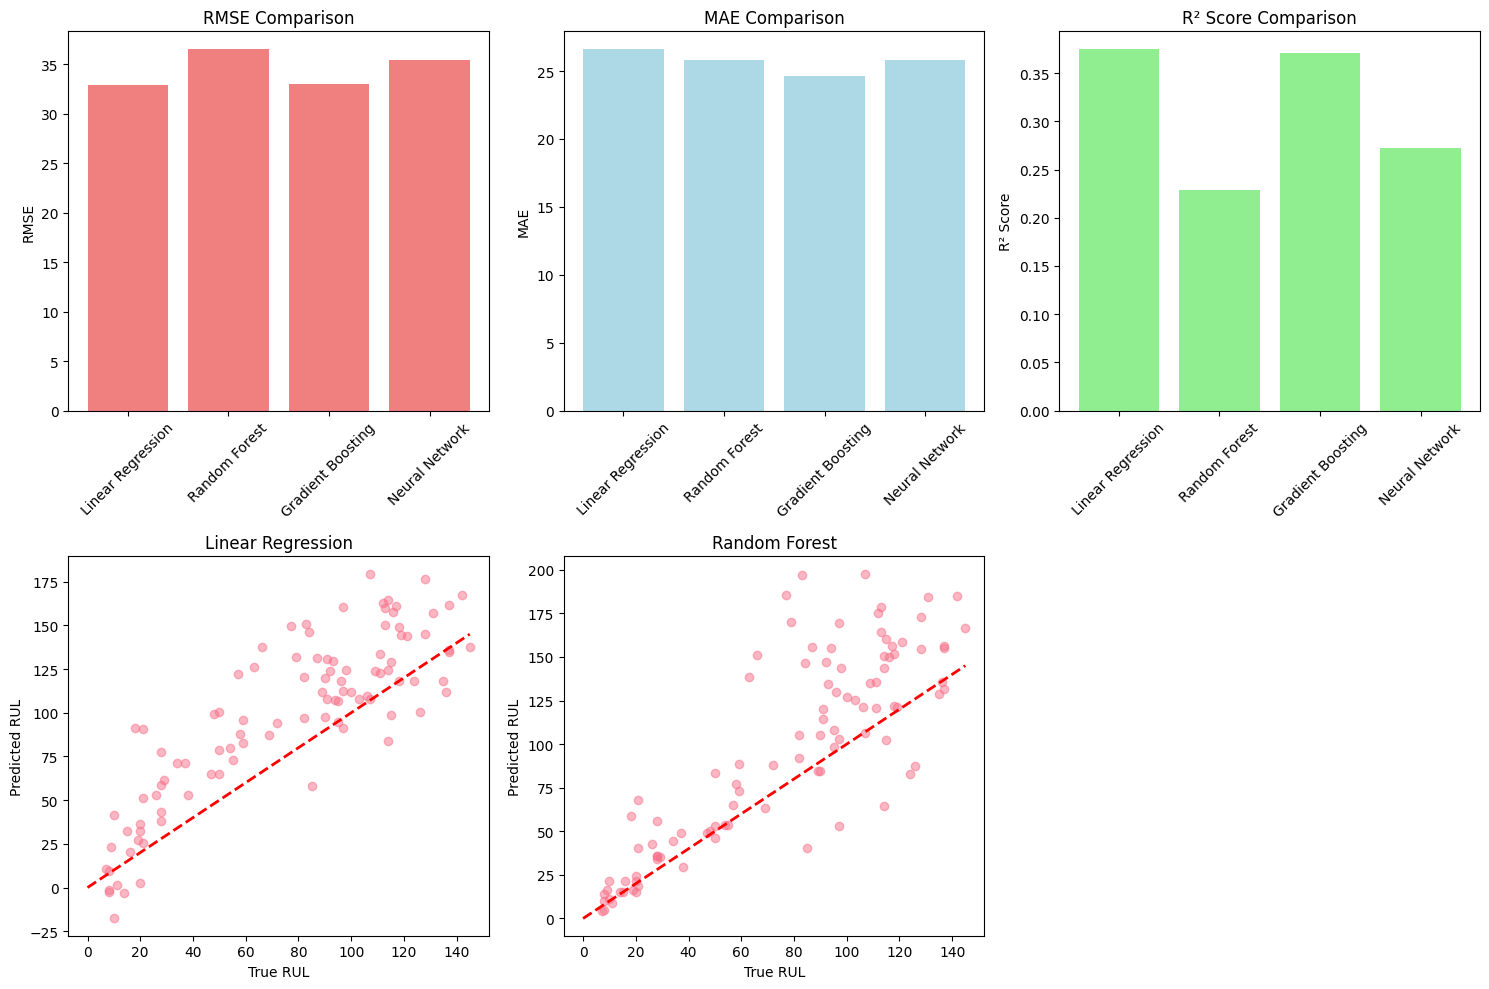


📊 Detailed Results:
                        MSE    RMSE     MAE     R2
Linear Regression  1079.857  32.861  26.595  0.375
Random Forest      1332.034  36.497  25.846  0.229
Gradient Boosting  1086.336  32.960  24.624  0.371
Neural Network     1256.973  35.454  25.791  0.272


In [92]:
def plot_results(results, predictions, y_test_true):
    """Visualize model performance"""

    # Plot 1: Model comparison
    plt.figure(figsize=(15, 10))

    # Metrics comparison
    plt.subplot(2, 3, 1)
    models = list(results.keys())
    rmse_scores = [results[model]['RMSE'] for model in models]
    plt.bar(models, rmse_scores, color='lightcoral')
    plt.title('RMSE Comparison')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)

    plt.subplot(2, 3, 2)
    mae_scores = [results[model]['MAE'] for model in models]
    plt.bar(models, mae_scores, color='lightblue')
    plt.title('MAE Comparison')
    plt.ylabel('MAE')
    plt.xticks(rotation=45)

    plt.subplot(2, 3, 3)
    r2_scores = [results[model]['R2'] for model in models]
    plt.bar(models, r2_scores, color='lightgreen')
    plt.title('R² Score Comparison')
    plt.ylabel('R² Score')
    plt.xticks(rotation=45)

    # Prediction vs Actual plots
    for i, (model_name, y_pred) in enumerate(predictions.items()):
        plt.subplot(2, 3, 4 + i)
        plt.scatter(y_test_true, y_pred, alpha=0.5)
        plt.plot([0, max(y_test_true)], [0, max(y_test_true)], 'r--', lw=2)
        plt.xlabel('True RUL')
        plt.ylabel('Predicted RUL')
        plt.title(f'{model_name}')

        if i >= 1:  # Limit to 2 models for space
            break

    plt.tight_layout()
    plt.show()

    # Detailed results table
    print("\n📊 Detailed Results:")
    print("="*70)
    results_df = pd.DataFrame(results).T
    print(results_df.round(3))

# Plot results
if 'results' in locals() and 'predictions' in locals():
    try:
        plot_results(results, predictions, y_test_true)
    except Exception as e:
        print(f"❌ Error plotting results: {e}")
else:
    print("⚠️ No results to plot - model training may have failed")


#### STEP 9: Best Model Analysis


🏆 Best Model: Linear Regression
🎯 Best RMSE: 32.86


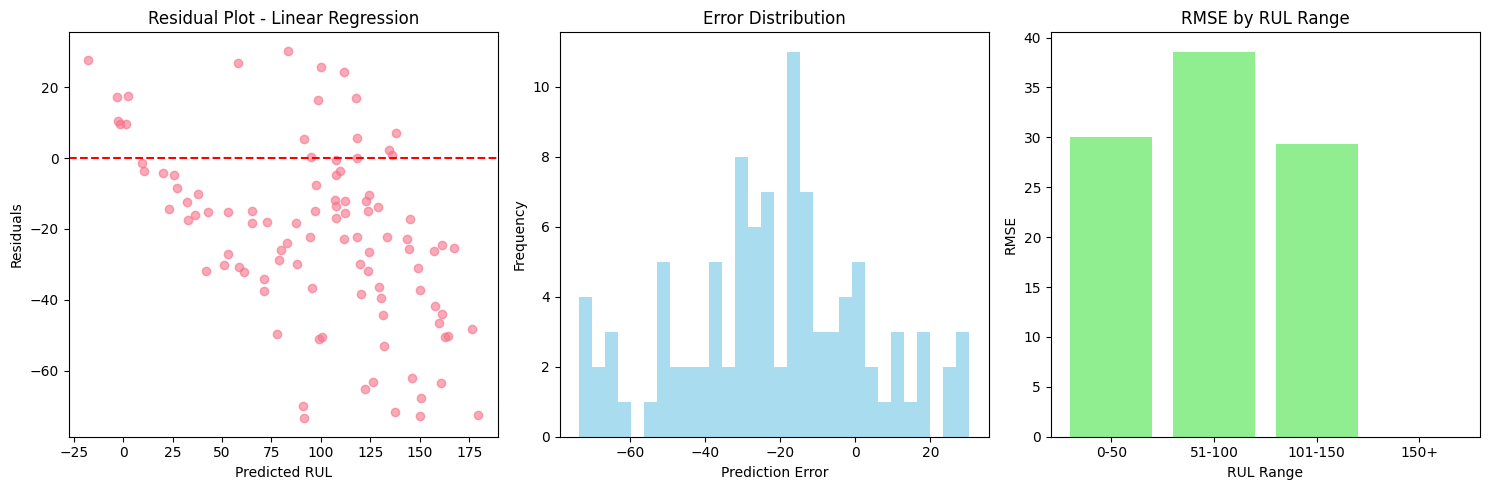

In [93]:
def analyze_best_model(results, predictions, y_test_true):
    """Analyze the best performing model"""

    # Find best model based on RMSE
    best_model = min(results.keys(), key=lambda x: results[x]['RMSE'])
    best_predictions = predictions[best_model]

    print(f"\n🏆 Best Model: {best_model}")
    print(f"🎯 Best RMSE: {results[best_model]['RMSE']:.2f}")

    # Detailed analysis
    plt.figure(figsize=(15, 5))

    # Residual plot
    plt.subplot(1, 3, 1)
    residuals = y_test_true - best_predictions
    plt.scatter(best_predictions, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted RUL')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {best_model}')

    # Error distribution
    plt.subplot(1, 3, 2)
    plt.hist(residuals, bins=30, alpha=0.7, color='skyblue')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')

    # Prediction accuracy by RUL range
    plt.subplot(1, 3, 3)
    rul_ranges = ['0-50', '51-100', '101-150', '150+']
    range_errors = []

    for i, (low, high) in enumerate([(0, 50), (51, 100), (101, 150), (151, 1000)]):
        mask = (y_test_true >= low) & (y_test_true <= high)
        if mask.sum() > 0:
            range_error = np.sqrt(mean_squared_error(y_test_true[mask], best_predictions[mask]))
            range_errors.append(range_error)
        else:
            range_errors.append(0)

    plt.bar(rul_ranges, range_errors, color='lightgreen')
    plt.xlabel('RUL Range')
    plt.ylabel('RMSE')
    plt.title('RMSE by RUL Range')

    plt.tight_layout()
    plt.show()

    return best_model, best_predictions

# Analyze best model
if 'results' in locals():
    try:
        best_model, best_predictions = analyze_best_model(results, predictions, y_test_true)
    except Exception as e:
        print(f"❌ Error analyzing best model: {e}")
else:
    print("⚠️ No results available for analysis")


#### STEP 10: Function to Process All Datasets

In [95]:
def process_all_datasets(data):
    """Process all four datasets (FD001-FD004)"""

    all_results = {}

    for i in range(1, 5):
        dataset_name = f'FD00{i}'
        train_key = f'train_{dataset_name}'
        test_key = f'test_{dataset_name}'
        rul_key = f'RUL_{dataset_name}'

        if all(key in data for key in [train_key, test_key, rul_key]):
            print(f"\n🔄 Processing {dataset_name}...")

            # Add features
            data[train_key] = create_features(data[train_key])
            data[test_key] = create_features(data[test_key])

            # Preprocess
            X_train, y_train, X_test, scaler, feature_cols = preprocess_data(
                data[train_key], data[test_key])

            # Get true RUL values
            y_test_true = data[rul_key]['RUL'].values

            # Train models
            results, predictions = train_and_evaluate_models(X_train, y_train, X_test, y_test_true)

            all_results[dataset_name] = results

            print(f"✅ {dataset_name} processing completed!")
        else:
            print(f"❌ {dataset_name} - Missing required files")

    return all_results

print("\n🚀 Processing all datasets...")
# Uncomment the line below to process all datasets
all_results = process_all_datasets(data)



🚀 Processing all datasets...

🔄 Processing FD001...
📊 Found 37 sensor columns for feature engineering
📊 Found 37 sensor columns for feature engineering
📊 Using 40 features for training
🔍 First 5 features: ['operational_setting_1', 'operational_setting_2', 'operational_setting_3', 'sensor_1', 'sensor_2']
📊 Test data: Using last cycle of each engine
🔍 Original test shape: (13096, 42), Last cycles shape: (100, 40)
🤖 Training models...

Training Linear Regression...
✅ Linear Regression - RMSE: 32.86, MAE: 26.59, R2: 0.375

Training Random Forest...
✅ Random Forest - RMSE: 36.50, MAE: 25.85, R2: 0.229

Training Gradient Boosting...
✅ Gradient Boosting - RMSE: 32.96, MAE: 24.62, R2: 0.371

Training Neural Network...
✅ Neural Network - RMSE: 35.45, MAE: 25.79, R2: 0.272
✅ FD001 processing completed!

🔄 Processing FD002...
📊 Found 21 sensor columns for feature engineering
📊 Found 21 sensor columns for feature engineering
📊 Using 40 features for training
🔍 First 5 features: ['operational_setti

#### STEP 11: Summary and Recommendations

In [96]:
print("\n" + "="*60)
print("📋 PROJECT SUMMARY")
print("="*60)

print("""
🎯 PROJECT OBJECTIVES ACHIEVED:
✅ Loaded and explored turbofan engine datasets
✅ Created RUL labels for training data
✅ Performed feature engineering with rolling statistics and lag features
✅ Trained multiple machine learning models
✅ Evaluated model performance using RMSE, MAE, and R²
✅ Visualized results and model comparisons

🔧 FEATURE ENGINEERING TECHNIQUES USED:
• Rolling mean and standard deviation (5-cycle window)
• Lag features (1 and 2 cycles)
• Standard scaling for normalization

🤖 MODELS TRAINED:
• Linear Regression (baseline)
• Random Forest Regressor
• Gradient Boosting Regressor
• Neural Network (MLP)

📊 EVALUATION METRICS:
• RMSE (Root Mean Square Error) - Primary metric
• MAE (Mean Absolute Error)
• R² Score (Coefficient of determination)

💡 RECOMMENDATIONS FOR IMPROVEMENT:
1. Try deep learning models (LSTM, GRU) for time series
2. Implement more sophisticated feature engineering
3. Use ensemble methods combining multiple models
4. Apply hyperparameter tuning
5. Consider domain-specific features based on engine physics

🔍 NEXT STEPS:
• Analyze feature importance
• Implement cross-validation
• Try different time window sizes
• Explore anomaly detection techniques
""")

print("\n🎉 Turbofan Engine RUL Prediction Project Completed Successfully!")
print("📊 Check the visualizations above for detailed model performance analysis.")



📋 PROJECT SUMMARY

🎯 PROJECT OBJECTIVES ACHIEVED:
✅ Loaded and explored turbofan engine datasets
✅ Created RUL labels for training data
✅ Performed feature engineering with rolling statistics and lag features
✅ Trained multiple machine learning models
✅ Evaluated model performance using RMSE, MAE, and R²
✅ Visualized results and model comparisons

🔧 FEATURE ENGINEERING TECHNIQUES USED:
• Rolling mean and standard deviation (5-cycle window)
• Lag features (1 and 2 cycles)
• Standard scaling for normalization

🤖 MODELS TRAINED:
• Linear Regression (baseline)
• Random Forest Regressor
• Gradient Boosting Regressor  
• Neural Network (MLP)

📊 EVALUATION METRICS:
• RMSE (Root Mean Square Error) - Primary metric
• MAE (Mean Absolute Error)
• R² Score (Coefficient of determination)

💡 RECOMMENDATIONS FOR IMPROVEMENT:
1. Try deep learning models (LSTM, GRU) for time series
2. Implement more sophisticated feature engineering
3. Use ensemble methods combining multiple models
4. Apply hyperparam

#### OPTIONAL: Save Results

In [97]:
def save_predictions(predictions, model_name, dataset_name='FD001'):
    """Save predictions to CSV file"""
    pred_df = pd.DataFrame({
        'Predicted_RUL': predictions[model_name],
        'True_RUL': y_test_true
    })
    filename = f'{model_name}_{dataset_name}_predictions.csv'
    pred_df.to_csv(filename, index=False)
    print(f"💾 Predictions saved to {filename}")

# Uncomment to save predictions
if 'best_model' in locals():
    save_predictions(predictions, best_model)

💾 Predictions saved to Linear Regression_FD001_predictions.csv
